## Inverse Cooking: Recipe Generation from Food Images

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = ''

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'


# device = torch.device('cpu')
# map_loc = None


In [4]:
print(device)

cuda


In [5]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [6]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [7]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join('/home/ct2020dl5787/inversecooking/model/checkpoints', 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
model.reduction = 'none'
print ('loaded model')
print ("Elapsed time:", time.time() -t)


/home/ct2020dl5787/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 5.705836057662964


In [9]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))

to_input_transf = transforms.Compose(transf_list_batch)

In [10]:
# greedy = [True, False, False, False]
greedy = [True]
# beam = [-1, -1, -1, -1]
beam = [-1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [11]:
import requests
from io import BytesIO
import random
from collections import Counter
unpickled_df = pd.read_pickle("df_recipe1023.pkl")
use_urls = True # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join('/home/ct2020dl5787/inversecooking/data/'+'demo_imgs')
#TODO1:load data
if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

# demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
#          'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_urls = unpickled_df["url"].tolist()
demo_files = demo_urls if use_urls else demo_imgs

In [12]:
demo_files[:10]

['http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/47/91/49/picaYYmb9.jpg',
 'https://img-global.cpcdn.com/001_recipes/5806945844854784/0x0/photo.jpg',
 'http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/40/86/94/picNQPjbC.jpg',
 'http://tastykitchen.com/recipes/wp-content/uploads/sites/2/2011/06/IMG_2692-630x420-410x615.jpg',
 'http://assets.epicurious.com/photos/5609a4d662fa7a9917c25748/master/pass/351294_hires.jpg',
 'http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/30/53/85/picZAmxgu.jpg',
 'https://img-global.cpcdn.com/001_recipes/5205549177110528/0x0/photo.jpg',
 'http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/37/19/14/pic8wSA2x.jpg',
 'http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/30/40/6/30406.jpg',
 'https://img-global.cpcdn.com/001_photo_reports/4904504583

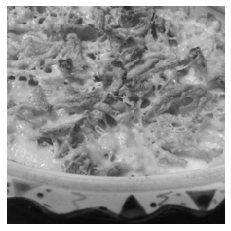

RECIPE 1

Title: Creamy chocolate milkshake

Ingredients:
cream, milk

Instructions:
-In a blender, combine ice cream, milk and chocolate chips.
-Blend until smooth.
-Pour into glasses and serve.


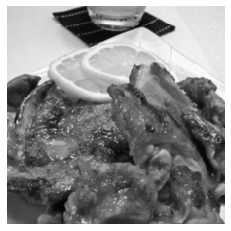

RECIPE 1

Title: Sour cream onion soup

Ingredients:
pepper, salt, onion, cream

Instructions:
-In a large saucepan, combine the sour cream, onion, salt and pepper.
-Bring to a boil over medium heat.
-Reduce heat to low and simmer, uncovered, for 10 minutes.


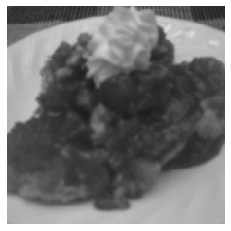

RECIPE 1

Title: Blueberry ice cream

Ingredients:
sugar, blueberries, cream, milk, extract

Instructions:
-In a large bowl, combine the milk, sugar, and vanilla.
-Stir in the blueberries.
-Pour into an ice cream maker and freeze according to manufacturer's instructions.


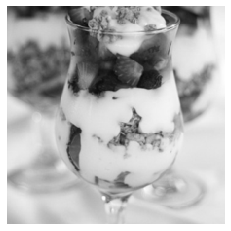

RECIPE 1

Title: Blueberry limeade

Ingredients:
blueberries, sugar, ice, juice

Instructions:
-In a blender, combine the blueberries, lime juice, sugar and ice cubes.
-Blend until smooth.
-Pour into glasses and serve.


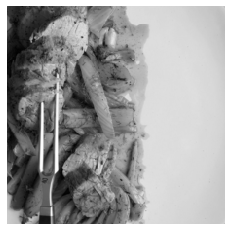

RECIPE 1

Title: Cucumber salad

Ingredients:
cucumber, salt, onion, pepper

Instructions:
-Peel cucumbers and slice into 1/4 inch slices.
-Place in a bowl and sprinkle with salt.
-Let stand for 30 minutes.
-Drain and rinse with cold water.
-Drain again.
-In a large bowl, combine cucumbers, onion, and pepper.
-Toss with dressing.
-Cover and chill for at least 2 hours.


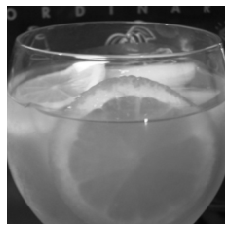

RECIPE 1

Title: The ultimate cosmopolitan

Ingredients:
juice, vodka, ice, rum, liqueur

Instructions:
-Add all ingredients to a cocktail shaker with ice.
-Shake well.
-Strain into a chilled cocktail glass.


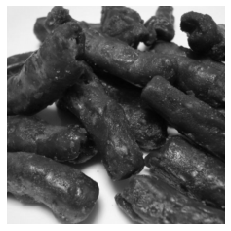

RECIPE 1

Title: Homemade salt

Ingredients:
pepper, salt

Instructions:
-Mix all ingredients together.
-Store in an airtight container.


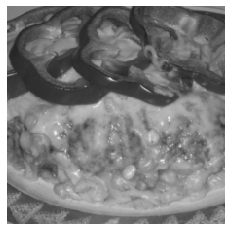

RECIPE 1

Title: Cream cheese sauce

Ingredients:
cheese, onion, pepper, milk, salt

Instructions:
-Mix all ingredients together.
-Refrigerate.


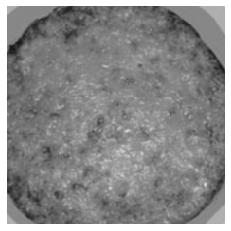

RECIPE 1

Title: Homemade pancake mix

Ingredients:
salt, milk, sugar, flour, water, egg

Instructions:
-Mix all ingredients together.
-Store in an airtight container.
-To use: mix 1 cup of mix with 1 cup of water.


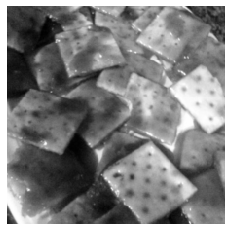

RECIPE 1

Title: Homemade yogurt

Ingredients:
yogurt, milk, sugar

Instructions:
-Mix all ingredients together.
-Let sit in fridge for about an hour.
-Enjoy !


In [ ]:
img_transf_index = 0
info_all = []
err_pic = []
start = time.time()
for img_file in demo_files:
    
#     if use_urls:
#         response = requests.get(img_file)
#         image = Image.open(BytesIO(response.content))
#     else:
#         image_path = os.path.join(image_folder, img_file)
#         image = Image.open(image_path).convert('RGB')
    response = requests.get(img_file)
    try:
        image = Image.open(BytesIO(response.content))
    

        transf_list = []
        
        #randomly modify the color
        transf_list.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.25))

        #randomly change some picture to greyscale
        transf_list.append(transforms.RandomGrayscale(p=1.0))

        transf_list.append(transforms.Resize(256))
        transf_list.append(transforms.CenterCrop(224))
        transform = transforms.Compose(transf_list)

        image_transf = transform(image)
        image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)

        if (img_transf_index < 10):
            plt.imshow(image_transf)
            plt.axis('off')
            plt.show()
            plt.close()

        num_valid = 1

        generate_ing = []
        generate_recipt = []
        generate_title = []
        generate_score = []
        for i in range(numgens):
            with torch.no_grad():
                outputs = model.sample(image_tensor, greedy=greedy[i],temperature=temperature, beam=beam[i], true_ingrs=None)
            ingr_ids = outputs['ingr_ids'].cpu().numpy()
            recipe_ids = outputs['recipe_ids'].cpu().numpy()

            outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
            #TODO2: Save output  
            generate_ing.append(outs['ingrs'])
            generate_recipt.append(outs['recipe'])
            generate_title.append(outs['title'])
            generate_score.append([valid['is_valid'],valid['score']])
            if (img_transf_index < 10):
                if valid['is_valid'] or show_anyways:

                    print ('RECIPE', num_valid)
                    num_valid+=1
                    #print ("greedy:", greedy[i], "beam:", beam[i])

                    BOLD = '\033[1m'
                    END = '\033[0m'
                    print (BOLD + '\nTitle:' + END,outs['title'])

                    print (BOLD + '\nIngredients:'+ END)
                    print (', '.join(outs['ingrs']))

                    print (BOLD + '\nInstructions:'+END)
                    print ('-'+'\n-'.join(outs['recipe']))

                    print ('='*20)

                else:
                    pass
                    print ("Not a valid recipe!")
                    print ("Reason: ", valid['reason'])
            
            info_all.append([img_file,generate_ing, generate_recipt,generate_title,generate_score])
            img_transf_index += 1
    except:
        pass
        
print(start-time.time())
    

In [ ]:
print(info_all[10])

In [ ]:
generate_data = pd.DataFrame(info_all,columns = ['url','generate_ingre','generate_reci','generate_title','generate_score'])
all_info = pd.merge(unpickled_df, generate_data , how='inner', on=['url'])
all_info.to_pickle('output/df_colorchanged_BW_1000.pkl')